# Notebook to train models

In [1]:
# Load packages
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import numpy as np
import random
import time as time
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import warnings
import umap

from models import cl_dummy_model1 as scRNASeq_model
from functions import data_preprocessing as dp

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
file = '../../data/processed/immune_cells/bone_marrow_human/BM_1_adata.h5ad'#'../../data/processed/immune_cells/merged/Oetjen_merged.h5ad' '../../data/processed/immune_cells/merged/Immune_cells_merged_all.h5ad'
adata = sc.read(file, cache=True)

In [3]:
# Visualize data
visualize = False

if visualize:
    vis_adata = adata.copy()
    sc.pp.highly_variable_genes(vis_adata, n_top_genes=4000, flavor="cell_ranger")

    # Scale data using dp.scale_data() to subtract data by the mean of each feature and divide by the std of that feature.
    # This was done as a preprocessing step for annotating cell types in ScType in R and will therefore be used for visualization purpose. 
    # https://github.com/satijalab/seurat/issues/1166  
    vis_adata.X = dp.scale_data(vis_adata.X)

    sc.pp.pca(vis_adata, n_comps=40, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(vis_adata, n_neighbors=15, n_pcs=40)
    sc.tl.umap(vis_adata)
    sc.pl.umap(vis_adata, color='cell_type')

    # PatientID batch-effect
    sc.pl.umap(vis_adata, color='patientID')

    # Tissue batch-effect
    sc.pl.umap(vis_adata, color='tissue')

    # Visualize distribution of cell types
    cell_types = adata.obs["cell_type"]

    cell_type_counts = {}
    for string in cell_types:
        if string in cell_type_counts:
            cell_type_counts[string] += 1
        else:
            cell_type_counts[string] = 1

    sorted_data = sorted(cell_type_counts.items(), key=lambda x: x[1], reverse=False)
    unique_strings, counts = zip(*sorted_data)

    bar_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in unique_strings]

    plt.barh(unique_strings, counts, color=bar_colors)

    plt.xlabel('Number of Cells')
    plt.ylabel('Cell Type')
    plt.title('Distribution of Cell Types')

    plt.tight_layout()
    plt.show()

In [4]:
# Class for retrieving data
data_env = scRNASeq_model.prep_data(adata=adata, HVG=True, Scaled=False, HVGs=4000)

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [5]:
# Define model
model = scRNASeq_model.model(input_dim=data_env.X.shape[1],
                                 attn_embed_dim=24, 
                                 output_dim=200)

print(model)
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

model(
  (blocks): ModuleList(
    (0): AttentionBlock(
      (attnblock_norm1): LayerNorm((4000,), eps=1e-05, elementwise_affine=True)
      (attnblock_attn): MultiheadAttention(
        (qkv_proj): CustomScaleModule()
        (o_proj): Linear(in_features=24, out_features=1, bias=True)
        (attn_dropout1): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm_layer_in): LayerNorm((4000,), eps=1e-05, elementwise_affine=True)
  (classifier_linear1): Linear(in_features=4000, out_features=1000, bias=True)
  (norm_layer1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (classifier__drop1): Dropout(p=0.3, inplace=False)
  (classifier_linear1_act): Tanh()
  (classifier_linear2): Linear(in_features=1000, out_features=200, bias=True)
)
Parameter blocks.0.attnblock_norm1.weight, shape torch.Size([4000])
Parameter blocks.0.attnblock_norm1.bias, shape torch.Size([4000])
Parameter blocks.0.attnblock_attn.qkv_proj.weight, shape torch.Size([4000, 72])
Parameter blocks.0.attnblock_att

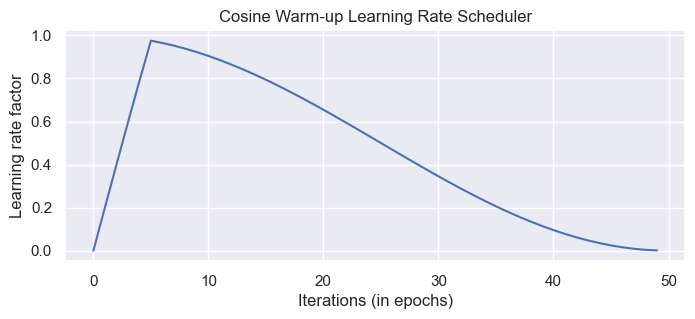

In [6]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    """
    From: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
    """

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=5, max_iters=50)

# Plotting
epochs = list(range(50))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in epochs)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [7]:
# Earlystopping
class EarlyStopping:
    """
    Early Stopping Callback for Training

    This class is a callback for early stopping during training based on validation loss. It monitors the validation loss and stops training if the loss does not improve for a certain number of consecutive epochs.

    Args:
        tolerance (int, optional): Number of epochs to wait for an improvement in validation loss before stopping. Default is 10.
    """
    
    def __init__(self, tolerance=10):

        self.tolerance = tolerance
        self.min_val = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss >= self.min_val:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else:
            self.min_val = val_loss
            self.counter = 0


class SNNLoss(nn.Module):
    """
    Soft Nearest Neighbor Loss

    This PyTorch loss function computes the Soft Nearest Neighbor (SNN) loss for a given set of input vectors and their corresponding targets. The SNN loss encourages the similarity between vectors of the same class while discouraging the similarity between vectors of different classes.

    Args:
        use_weights (bool, optional): If True, calculate class weights based on label frequency. Default is True.
        targets (Tensor, optional): A tensor containing the class labels for the input vectors. Required if use_weights is True.
        temperature (float, optional): A scaling factor applied to the cosine similarity. Default is 1.0.
    """
    def __init__(self, use_weights: bool=True, targets=None, temperature: float=1.0, device: str="cuda"):
        super(SNNLoss, self).__init__()
        
        self.temperature = temperature
        self.device = device
        self.use_weights = use_weights

        # Calculate weights for the loss based on label frequency
        if self.use_weights:
            if targets is not None:
                self.weight = self.calculate_class_weights(targets)
            else:
                raise ValueError("'use_weights' is True, but 'targets' is not provided.")

    def calculate_class_weights(self, targets):
        """
        Calculate class weights based on label frequency.

        Args:
            targets (Tensor): A tensor containing the class labels.
        """

        class_counts = torch.bincount(targets)  # Count the occurrences of each class
        class_weights = 1.0 / class_counts.float()  # Calculate inverse class frequencies
        class_weights /= class_weights.sum()  # Normalize to sum to 1

        class_weight_dict = {class_label: weight for class_label, weight in enumerate(class_weights)}

        return class_weight_dict

    def forward(self, input, targets):
        """
        Compute the SNN loss for the input vectors and targets.

        Args:
            input (Tensor): Input vectors.
            targets (Tensor): Class labels for the input vectors.
        """

        # Calculate the cosine similarity matrix
        cosine_similarity_matrix = F.cosine_similarity(input.unsqueeze(1), input.unsqueeze(0), dim=2) / self.temperature

        # Define a loss dictionary containing the loss of each label
        loss_dict = {str(target): torch.tensor([]).to(self.device) for target in targets.unique()}
        for idx, (sim_vec, target) in enumerate(zip(cosine_similarity_matrix,targets)):
            positiv_samples = torch.sum(torch.exp(sim_vec[(targets == target)])) - torch.exp(sim_vec[idx])
            negativ_samples = torch.sum(torch.exp(sim_vec[(targets != target)]))
            loss = -torch.log(positiv_samples / (positiv_samples + negativ_samples))
            loss_dict[str(target)] = torch.cat((loss_dict[str(target)], loss.unsqueeze(0)))

        # Calculate the weighted average loss
        weighted_losses = []
        for target in targets.unique():
            if len(targets[targets==target]) > 1: # Skip if there's only one sample of given label in the batch
                losses_for_target = loss_dict[str(target)]
                if self.use_weights:
                    weighted_loss = torch.mean(losses_for_target) * self.weight[int(target)]
                else:
                    weighted_loss = torch.mean(losses_for_target)
                weighted_losses.append(weighted_loss)

        loss = torch.mean(torch.stack(weighted_losses))

        return loss

# Train model
def train_model(model, optimizer, lr_scheduler, loss_module, device, out_path, train_loader, val_loader, fold_idx, print_rate=10, num_epochs=10, earlystopping_threshold=10):

    print()
    print(f"Start Training CV fold {fold_idx+1}")
    print()

    # Add model to device
    model.to(device)

    # Initiate EarlyStopping
    early_stopping = EarlyStopping(earlystopping_threshold)

    # Training loop
    best_val_loss = np.inf  
    best_val_acc = 0.0
    best_preds = []
    train_start = time.time()
    for epoch in tqdm(range(num_epochs)):

        # Training
        model.train()
        train_loss = []
        all_train_preds = []
        all_train_labels = []
        for data_inputs, data_labels in train_loader:

            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            optimizer.zero_grad()
            preds = model(data_inputs)

            loss = loss_module(preds, data_labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            all_train_preds.extend(preds.cpu().detach().numpy())
            all_train_labels.extend(data_labels.cpu().detach().numpy())

        # Validation
        model.eval()
        val_loss = []
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data_inputs, data_labels in val_loader:

                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)

                preds = model(data_inputs)

                loss = loss_module(preds, data_labels)
                val_loss.append(loss.item())

                all_preds.extend(preds.cpu().detach().numpy())
                all_labels.extend(data_labels.cpu().detach().numpy())

        # Metrics
        avg_train_loss = sum(train_loss) / len(train_loss)
        train_accuracy = 0.
        avg_val_loss = sum(val_loss) / len(val_loss)
        accuracy = 0.
        f1 = 0.

        # Check early stopping
        early_stopping(avg_val_loss)

        # Print epoch information
        if (epoch % print_rate == 0) or (epoch == (num_epochs-1)) or (early_stopping.early_stop):
            print(f"Epoch {epoch+1} | Training loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f} | Validation loss: {avg_val_loss:.4f} | Validation Accuracy: {accuracy:.4f} | Validation F1 Score: {f1:.4f}")

        # Update learning rate
        lr_scheduler.step()

        # Apply early stopping
        if early_stopping.early_stop:
            print(f"Stopped training using EarlyStopping at epoch {epoch+1}")
            break

        # Save model if performance have improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = accuracy
            best_preds = all_preds
            torch.save(model, f'{out_path}model_CV_{fold_idx+1}.pt')

    print()
    print(f"**Finished training CV fold {fold_idx+1}**")
    print()
    train_end = time.time()
    print(f"Training time: {(train_end - train_start)/60:.2f} minutes")

    return best_val_loss, best_val_acc, best_preds


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Ensure reproducibility
def rep_seed(seed):
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 42
rep_seed(seed)

# StratifiedKFold cross-validation
cv_losses = []
cv_accs = []
all_preds = []
all_preds_indices = []
folds = 5
batch_size = 256#8
total_train_start = time.time()
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
for fold_idx, (train_indices, val_indices) in enumerate(skf.split(data_env.X, data_env.labels)):

    train_data = data.Subset(data_env, train_indices)
    val_data = data.Subset(data_env, val_indices)

    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = data.DataLoader(val_data, batch_size=batch_size)

    model = scRNASeq_model.model(input_dim=data_env.X.shape[1],
                                 attn_embed_dim=24, 
                                 depth=4,
                                 num_heads=1,
                                 output_dim=200)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {total_params}")

    loss_module = SNNLoss(use_weights=True, targets=torch.tensor(train_data.dataset.target), temperature=0.5)#nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)
    lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=4, max_iters=25)
    out_path = "trained_models/cl_dummy_models1/"

    cv_loss, cv_acc, preds = train_model(model=model, 
                                optimizer=optimizer, 
                                lr_scheduler=lr_scheduler, 
                                loss_module=loss_module, 
                                device=device, 
                                out_path=out_path,
                                train_loader=train_loader, 
                                val_loader=val_loader,
                                fold_idx=fold_idx,
                                print_rate=2,
                                num_epochs=20, 
                                earlystopping_threshold=10)
    
    cv_losses.append(cv_loss)
    cv_accs.append(cv_acc)
    all_preds.extend(preds)
    all_preds_indices.extend(val_indices)

    del model, loss_module, optimizer, lr_scheduler

    break # break for now, run for 1 fold

print()
print(f"CV loss score: {np.mean(cv_losses):.4f}")
print(f"CV accuracy score: {np.mean(cv_accs):.4f}")
print()

total_train_end = time.time()
print(f"Total training time: {(total_train_end - total_train_start)/60:.2f} minutes")

Number of parameters: 5395300

Start Training CV fold 1



  5%|▌         | 1/20 [00:06<02:05,  6.59s/it]

Epoch 1 | Training loss: 0.2488 | Training Accuracy: 0.0000 | Validation loss: 0.2376 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 15%|█▌        | 3/20 [00:17<01:41,  5.96s/it]

Epoch 3 | Training loss: 0.1677 | Training Accuracy: 0.0000 | Validation loss: 0.1516 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 25%|██▌       | 5/20 [00:30<01:34,  6.29s/it]

Epoch 5 | Training loss: 0.1457 | Training Accuracy: 0.0000 | Validation loss: 0.1406 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 35%|███▌      | 7/20 [00:43<01:23,  6.43s/it]

Epoch 7 | Training loss: 0.1358 | Training Accuracy: 0.0000 | Validation loss: 0.1357 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 45%|████▌     | 9/20 [00:56<01:10,  6.44s/it]

Epoch 9 | Training loss: 0.1341 | Training Accuracy: 0.0000 | Validation loss: 0.1342 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 55%|█████▌    | 11/20 [01:09<00:58,  6.52s/it]

Epoch 11 | Training loss: 0.1249 | Training Accuracy: 0.0000 | Validation loss: 0.1337 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 65%|██████▌   | 13/20 [01:23<00:46,  6.59s/it]

Epoch 13 | Training loss: 0.1297 | Training Accuracy: 0.0000 | Validation loss: 0.1338 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 75%|███████▌  | 15/20 [01:37<00:33,  6.78s/it]

Epoch 15 | Training loss: 0.1282 | Training Accuracy: 0.0000 | Validation loss: 0.1342 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 85%|████████▌ | 17/20 [01:50<00:20,  6.69s/it]

Epoch 17 | Training loss: 0.1221 | Training Accuracy: 0.0000 | Validation loss: 0.1333 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


 95%|█████████▌| 19/20 [02:03<00:06,  6.65s/it]

Epoch 19 | Training loss: 0.1228 | Training Accuracy: 0.0000 | Validation loss: 0.1337 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000


100%|██████████| 20/20 [02:10<00:00,  6.52s/it]

Epoch 20 | Training loss: 0.1244 | Training Accuracy: 0.0000 | Validation loss: 0.1331 | Validation Accuracy: 0.0000 | Validation F1 Score: 0.0000

**Finished training CV fold 1**

Training time: 2.17 minutes

CV loss score: 0.1331
CV accuracy score: 0.0000

Total training time: 2.18 minutes


C:\Users\user\AppData\Local\Temp\ipykernel_16316\457336142.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  loss = loss_module(torch.tensor(all_X),torch.tensor(all_preds_ordered))


Loss: 0.24569852650165558


c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\user\AppData\Local\Temp\ipykernel_16316\457336142.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', len(color_map.cat.categories))


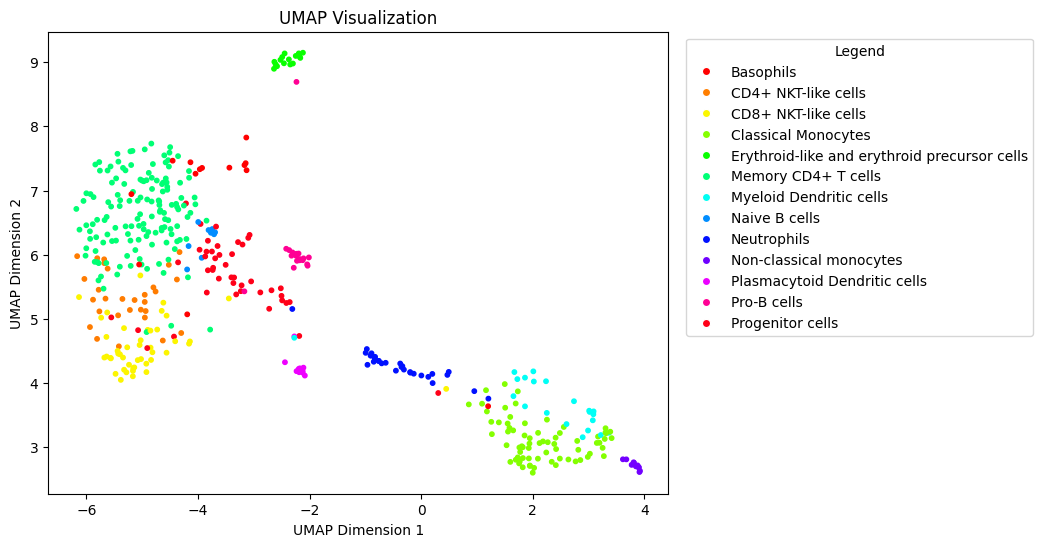

In [8]:
# From begining
#loss_module = SNNLoss(use_weights=True, targets=torch.tensor(train_data.dataset.target), temperature=1.0, device="cpu")#nn.CrossEntropyLoss()
loss_module = SNNLoss(use_weights=True, targets=torch.tensor(data_env.target), temperature=1.0, device="cpu")#nn.CrossEntropyLoss()

all_preds_ordered = []
all_X = []
for i in all_preds_indices:
    all_preds_ordered.append(data_env.target[i])
    all_X.append(data_env.X[i].numpy())

loss = loss_module(torch.tensor(all_X),torch.tensor(all_preds_ordered))
print(f"Loss: {loss}")

# Reverse transform labels
#all_preds_ordered = data_env.label_encoder.inverse_transform(all_preds_ordered)

# Create a UMAP embedding
umap_model = umap.UMAP(n_neighbors=15, random_state=42)
umap_embedding = umap_model.fit_transform(all_X)

# Create a color mapping for the legend
color_map = pd.Series(all_preds_ordered, dtype="category")
cmap = plt.cm.get_cmap('hsv', len(color_map.cat.categories))

# Visualize the UMAP embedding with a legend
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=color_map.cat.codes, cmap='hsv', s=10)
plt.title('UMAP Visualization')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Add a legend to the right of the plot
legend_labels = {cat: str(data_env.label_encoder.inverse_transform([cat])[0]) for cat in color_map.cat.categories}
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[cat], markerfacecolor=cmap(i / len(color_map.cat.categories))) for i, cat in enumerate(color_map.cat.categories)]
plt.legend(handles=handles, title='Legend', bbox_to_anchor=(1.6, 1), loc='upper right')

plt.show()

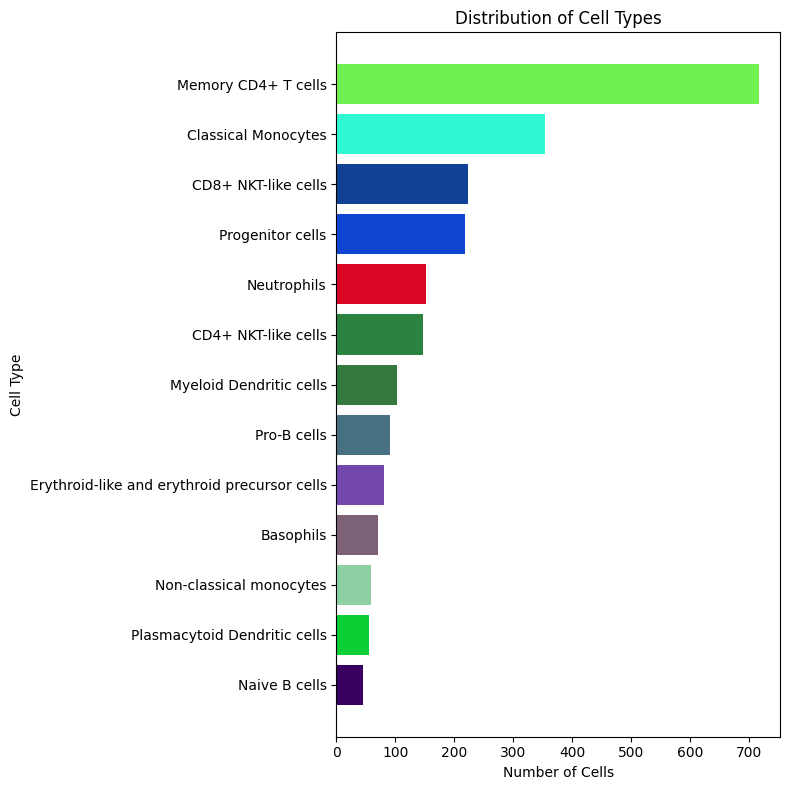

In [9]:
import matplotlib.pyplot as plt
import random

# Visualize distribution of cell types
cell_types = data_env.labels#all_preds_ordered

cell_type_counts = {}
for string in cell_types:
    if string in cell_type_counts:
        cell_type_counts[string] += 1
    else:
        cell_type_counts[string] = 1

sorted_data = sorted(cell_type_counts.items(), key=lambda x: x[1], reverse=False)
unique_strings, counts = zip(*sorted_data)

bar_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in unique_strings]

plt.figure(figsize=(8,8))
plt.barh(unique_strings, counts, color=bar_colors)

plt.xlabel('Number of Cells')
plt.ylabel('Cell Type')
plt.title('Distribution of Cell Types')

plt.tight_layout()
plt.show()

Loss: 0.18657651543617249


c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\user\AppData\Local\Temp\ipykernel_16316\3311931696.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', len(color_map.cat.categories))


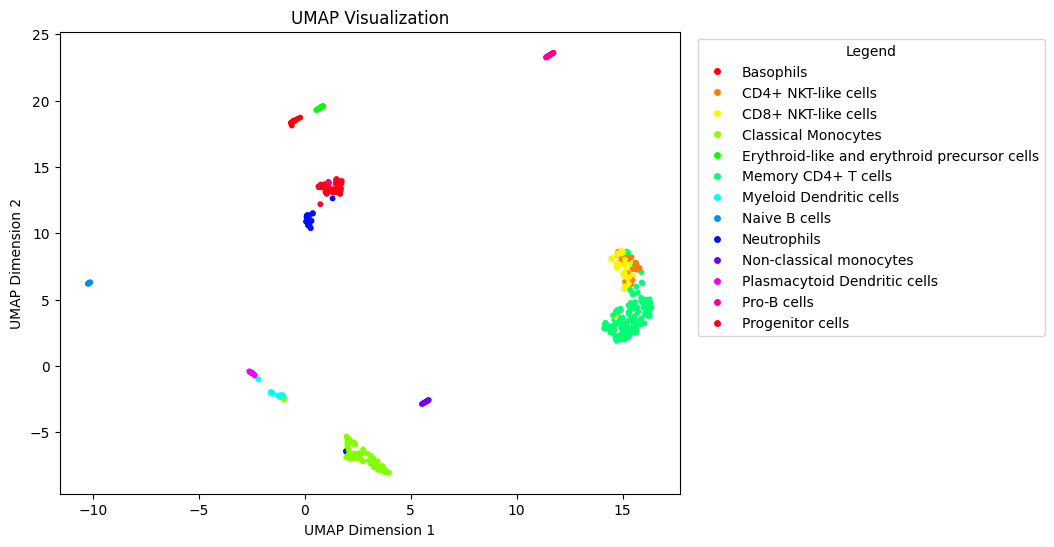

In [11]:
# After model

all_preds_ordered = []
for i in all_preds_indices:
    all_preds_ordered.append(data_env.target[i])

loss = loss_module(torch.tensor(all_preds),torch.tensor(all_preds_ordered))
print(f"Loss: {loss}")

# Reverse transform labels
#all_preds_ordered = data_env.label_encoder.inverse_transform(all_preds_ordered)

# Create a UMAP embedding
umap_model = umap.UMAP(n_neighbors=15, random_state=42)
umap_embedding = umap_model.fit_transform(all_preds)

# Create a color mapping for the legend
color_map = pd.Series(all_preds_ordered, dtype="category")
cmap = plt.cm.get_cmap('hsv', len(color_map.cat.categories))

# Visualize the UMAP embedding with a legend
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=color_map.cat.codes, cmap='hsv', s=10)
plt.title('UMAP Visualization')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Add a legend to the right of the plot
legend_labels = {cat: str(data_env.label_encoder.inverse_transform([cat])[0]) for cat in color_map.cat.categories}
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[cat], markerfacecolor=cmap(i / len(color_map.cat.categories))) for i, cat in enumerate(color_map.cat.categories)]
plt.legend(handles=handles, title='Legend', bbox_to_anchor=(1.6, 1), loc='upper right')

plt.show()